<a href="https://colab.research.google.com/github/yda-cyber/Hallucinator/blob/main/Hallucinator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Hallucinator with Binding/Cavity Control

In [1]:
#@title Install Dependencies
# @markdown Install ESMFold, OpenFold and Hallucinator
# @markdown - This will approximately use 5.5 minutes
# @markdown - ESMFold can be used from ESMFold API (online, without GPU). Typically Faster for small proteins.

useESMFold = "online" # @param ["local", "online"]

import os
import time

os.system("pip install pyKVFinder==0.6.0")
os.system("pip install numpy==1.23.5")
os.system("git clone https://github.com/yda-cyber/Hallucinator.git")

# Install ADFR
if not os.path.isfile('install-ADFR'):
  print("[PREPR]: Installing ADFR.")
  os.system("wget -O install-ADFR https://ccsb.scripps.edu/adfr/download/1028/")
  os.system("chmod a+x install-ADFR")
  !echo -e "Y\n ADFR" | ./install-ADFR >/dev/null 2>&1
  os.chdir('ADFR/')
  os.system('tar -zxvf ADFRsuite_x86_64Linux_1.0.tar.gz')
  os.chdir('ADFRsuite_x86_64Linux_1.0/')
  os.system('echo -e "Y" | ./install.sh >/dev/null 2>&1')
  os.system('cp bin/prepare_receptor ../../.')
  os.chdir('../..')

if not os.path.isfile('qvina-w'):
  print("[PREPR]: Installing Qvina-W.")
  os.system("git clone https://github.com/QVina/qvina.git")
  os.system("chmod +x qvina/bin/qvina-w")
  os.system("cp qvina/bin/qvina-w .")

os.makedirs("results", exist_ok=True)
os.makedirs("molecules", exist_ok=True)

if useESMFold == 'local':
  if not os.path.isfile("esmfold.model"):

    os.system("apt-get install aria2 -qq")
    print("[PREPR]: Downloading ESMFold from ColabFold.")
    os.system(f"aria2c -q -x 16 https://colabfold.steineggerlab.workers.dev/esm/esmfold.model &")

    # wait for Params to finish downloading...
    if os.path.isfile(f"esmfold.model.aria2"):
      print("[PREPR]: Downloading in progress.")
    while os.path.isfile(f"esmfold.model.aria2"):
      time.sleep(5)

    if not os.path.isfile("FoldInstalled.state"):
      commit_id = "6908936b68ae89f67755240e2f588c09ec31d4c8"
      print("[PREPR]: Installing ESMfold Dependencies.")
      os.system("pip install -q omegaconf \"pytorch_lightning<2\" \"torch<2\" biopython ml_collections einops py3Dmol")
      os.system("pip install -q git+https://github.com/NVIDIA/dllogger.git")
      os.system(f"pip install -q git+https://github.com/aqlaboratory/openfold.git@{commit_id}")
      print("[PREPR]: Installing ESMfold")
      os.system("pip install -q git+https://github.com/sokrypton/esm.git")
      os.system("touch FoldInstalled.state")

[PREPR]: Installing ADFR.
[PREPR]: Installing Qvina-W.


In [2]:
#@title Import Losses and Modules

from Hallucinator.ProteinHallucination import Protein_History_MCMC_Logger

from Hallucinator.modules.Predict_ESM import predict_esm
from Hallucinator.modules.Compute_RMSD import compute_rmsd
from Hallucinator.modules.Init_Sequence import init_sequence
from Hallucinator.modules.Select_Mutation import select_mutation
from Hallucinator.modules.Mutations_BLOSUM62 import mutation_blosum62

from Hallucinator.loss.Loss_Function import LossFunction

from Hallucinator.loss.Compute_Cavity_Volume_Loss import CavityVolumeLoss
from Hallucinator.loss.Compute_Local_Distance_Loss import LocalDistanceLoss
from Hallucinator.loss.Compute_Secondary_Ratio_Loss import SecondaryRatioLoss
from Hallucinator.loss.Compute_Contact_Density_Loss import ContactDensityLoss
from Hallucinator.loss.Compute_Cavity_Similarity_Loss import CavitySimilarityLoss
from Hallucinator.loss.Compute_Cavity_Containing_Loss import CavityContainingLoss
from Hallucinator.loss.Compute_Protein_Containing_Loss import ProteinContainingLoss
from Hallucinator.loss.Compute_Preserve_Structure_Loss import PreserveStructureLoss
from Hallucinator.loss.Compute_Truncated_Average_PLDDT_Loss import TruncatedAveragePLDDTLoss
from Hallucinator.loss.Compute_Molecule_Binding_Affinity_Loss import MoleculeBindingAffinityLoss
from Hallucinator.loss.Compute_Cavity_Containing_Flexible_Loss import CavityContainingFlexibleLoss

In [3]:
#@title Basic Settings
Jobname = 'FixSequenceTestG' #@param {type:"string"}
Length = 100 #@param {type: "number"}
Steps = 10000 #@param {type: "number"}
Output_Render_Frequency = 100 #@param {type: 'number'}
Start_From_Known_Sequence = False #@param {type:"boolean"}
#@markdown - Only when you select to start from known sequence, the Intial Sequence and Preservation will be used
Initial_Sequence = 'PIAQIHILEGRSDEQKETLIREVSEAISRSLDAPLTSVRVIITEMAKGHFGIGGELASK' #@param {type:"string"}
Initial_Mutation_Rate = 30 #@param {type:"number"}
Preserved_Residues = "1; 10; 11" #@param {type:"string"}
#@markdown - Use ; to seperate unwanted amino acids
Exclude_Amino_Acid = "C;H" #@param {type:"string"}
#@markdown - Number of guesses before starting hallucination
N_Free_Guess = "10" #@param [0, 5, 10]
#@markdown - Rules for mixing multiple losses
Loss_Rule = 'Sum' #@param ['Sum', 'Max']

N_Free_Guess = int(N_Free_Guess)

In [4]:
#@title Set Loss.
#@markdown All Loss will be finally normalized. And Max_loss is used for Weighting.
#@markdown - For other loss or customizing loss, please use a downloaded version.


PLDDTLoss = []
POSLoss = []
#@markdown Parameters for Truncated PLDDT Loss (With max loss=1)
Truncated_PLDDT_Loss = True #@param {type:"boolean"}
target =  80 #@param {type:"number"}
pldd_target = target

if Truncated_PLDDT_Loss:
  PLDDTLoss += [TruncatedAveragePLDDTLoss(30, target)]

#@markdown Parameters for Contact Density Loss:
#@markdown - Enhance numbers of contact in proteins to make it globularm typically value: 0.035 for L<=150, 0.015 for L<=400
Contact_Density_Loss = True #@param {type:"boolean"}
target = 0.035 #@param {type:"number"}
max_loss =  2 #@param {type:"number"}
activate_PLDDT = 10 #@param {type: "number"}
cdl_max_loss, cdl_target, cdl_activate = max_loss, target, activate_PLDDT

if Contact_Density_Loss:
  POSLoss += [ContactDensityLoss(target_density=cdl_target, max_loss=cdl_max_loss,
                 plddt_activate_value=cdl_activate)]

#@markdown Parameters for Explicit Binding Loss (Time Consuming):
Explicit_Binding_Loss = False #@param {type:"boolean"}
#@markdown - Target value varies for different molecules, one can provide a positive numerical value or use Auto functions. Auto functions benchmarked the binding with N(N<=49) reference peptides and use 1.5*max(score)
#@markdown - The Auto function may need a significant amount of time (~Dock Ntimes)
target =  "Auto-5" #@param {type:"raw"}

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#

max_loss =  3 #@param {type:"number"}
activate_PLDDT = 50 #@param {type: "number"}
mbl_max_loss, mbl_target, mbl_activate = max_loss, target, activate_PLDDT
use_example = True #@param {type:"boolean"}
mbl_file = None

#@markdown - If you selected MBL (and not example), please upload the required file (Ligand in PDBQT Format). Examples are in Hallucinator/Molecules:
if Explicit_Binding_Loss and not use_example:
  from google.colab import files
  filename = files.upload()
  for f in filename:
    os.rename(f, f'molecules/{f}')
    print(f'Moved "{f}" to the ./molecules/ directory')
  mbl_file = 'molecules/'+f
if use_example:
  mbl_file = 'Hallucinator/molecules/Example.pdbqt'


if Explicit_Binding_Loss:
  POSLoss += [MoleculeBindingAffinityLoss(mbl_file, max_loss=mbl_max_loss,
                      target_score=mbl_target,
                      plddt_activate_value=mbl_activate)]

#@markdown Parameters for Implicit Cavity Loss (Time Efficient with Step>=0.5):
Implicit_Cavity_Loss = True #@param {type:"boolean"}
#@markdown - Target value varies for different molecules
Tolerate_Volume_Diff =  500 #@param {type:"number"}
#@markdown - Smaller Step will make cavity calculation more accurate but also more expensive
Step_KVFinder = 0.6 #@param {type:"number"}
#@markdown - Whether sidechains are ignored when calculating cavities.
Ignore_Sidechains = False #@param {type: "boolean"}
max_loss =  3 #@param {type:"number"}
activate_PLDDT = 50 #@param {type: "number"}
ccl_max_loss, ccl_activate = max_loss, activate_PLDDT
use_example = True #@param {type:"boolean"}
ccl_file = None

#@markdown - If you selected ICL (and not example), please upload the required file (Ligand in PDB Format, the Occ column to be vdw radius). Examples are in Hallucinator/Molecules:
if Implicit_Cavity_Loss and not use_example:
  from google.colab import files
  filename = files.upload()
  for f in filename:
    os.rename(f, f'molecules/{f}')
    print(f'Moved "{f}" to the ./molecules/ directory')
  ccl_file = 'molecules'+ f
if use_example:
  ccl_file = 'Hallucinator/molecules/Example.pdb'
print(ccl_file)

#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!TODO!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!#

if Implicit_Cavity_Loss:
  POSLoss += [CavityContainingLoss(ccl_file, volume_factor=0.01,
                  volume_expansion=Tolerate_Volume_Diff,
                  similarity_factor=20, similarity_target_diff=0,
                  sample_points=10, step=Step_KVFinder,
                  backbone_cavity=Ignore_Sidechains,
                  max_loss=ccl_max_loss, plddt_activate_value=ccl_activate)]



Hallucinator/molecules/Example.pdb
[CSLOG]: Targeted volume is 177.98


INFO:Logger:[JOBID]: Start with job name FixSequenceTestG.
INFO:Logger:[RANDS]: Random seed set as 1429173739
INFO:Logger:[SECIT]: Initial Sequence Random Generated.
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 3.31, 'Diff volume': 85.76, 'ConFactor': (0.13, 0.08, 0.01)}
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 0.52, 'Diff volume': 535.04, 'ConFactor': (0.32, 0.8, 0.58)}
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 0.63, 'Diff volume': 596.6, 'ConFactor': (0.14, 0.1, 0.72)}
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 0.67, 'Diff volume': 1473.34, 'ConFactor': (0.34, 0.85, 1.0)}
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 0.02, 'Diff volume': 243.87, 'ConFactor': (0.28, 0.63, 0.06)}
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 1.93, 'Diff volume': 1499.26, 'ConFactor': (0.3, 0.73, 1.0)}
INFO:Logger:[LSLOG]: Following info returned: {'Contact %': 2.89, 'Diff volume': 14.04, 'ConFactor': (0.26,

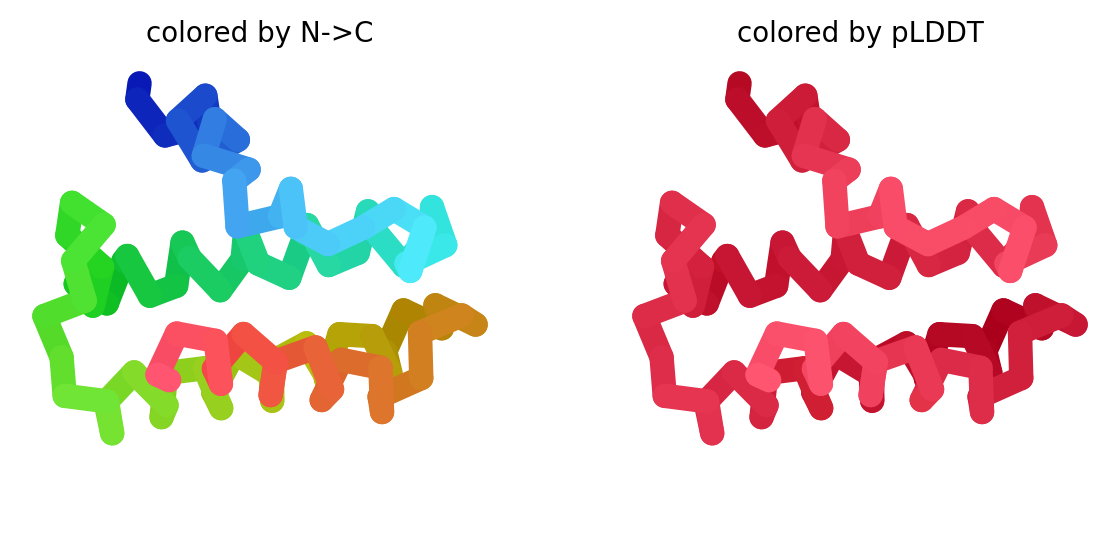

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 39.11, 'Contact %': 0.83}
INFO:Logger:[MCLOG]: Step: 101, New Loss: 0.955, Curr Loss: 0.935, Best Loss: 0.905, Accepted: × with temp 1.0 and prob 0.137
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 44.45, 'Contact %': 0.29}
INFO:Logger:[MCLOG]: Step: 102, New Loss: 0.928, Curr Loss: 0.928, Best Loss: 0.905, Accepted: √ with temp 1.0 and prob 1.000
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 42.64, 'Contact %': 0.74}
INFO:Logger:[MCLOG]: Step: 103, New Loss: 0.937, Curr Loss: 0.928, Best Loss: 0.905, Accepted: × with temp 1.0 and prob 0.408
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 43.3, 'Contact %': 0.81}
INFO:Logger:[MCLOG]: Step: 104, New Loss: 0.934, Curr Loss: 0.934, Best Loss: 0.905, Accepted: √ with temp 1.0 and prob 0.566
INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 43.64, 'Contact %': 1.03}
INFO:Logger:[MCLOG]: Step: 105, New Loss: 0.932, Curr Loss: 0.932, 

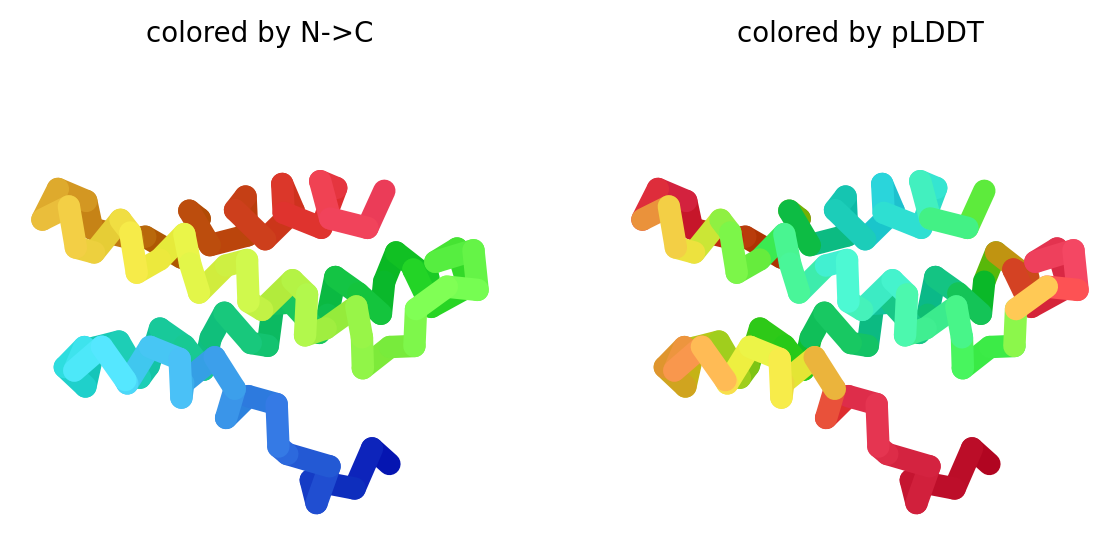

INFO:Logger:[LSLOG]: Following info returned: {'Ave Plddt': 64.49, 'Contact %': 1.37, 'Diff volume': 80.13, 'ConFactor': (0.54, 1, 1)}


[JODID]: Job finished with id:FixSequenceTestG


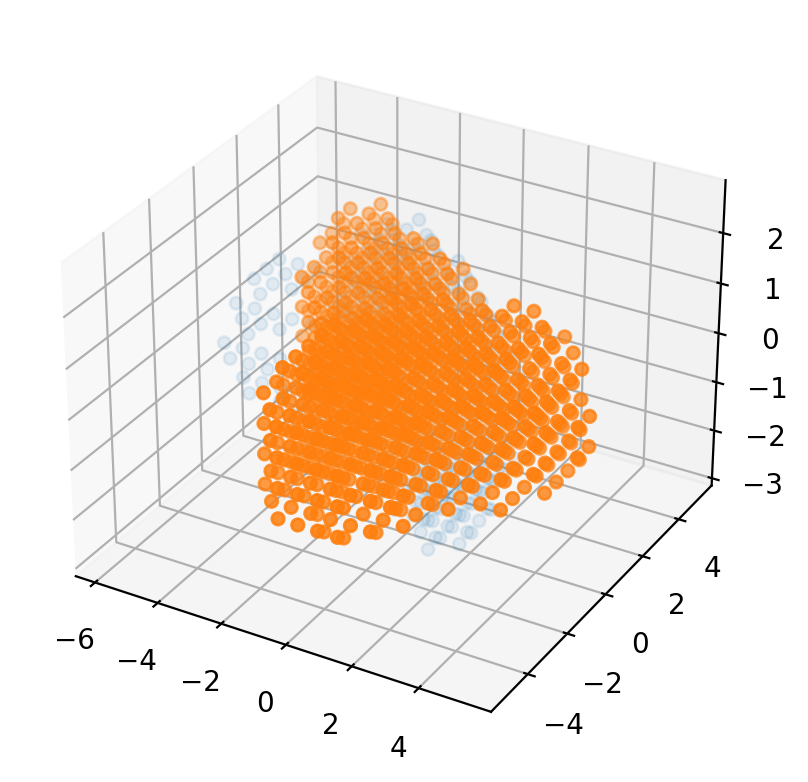

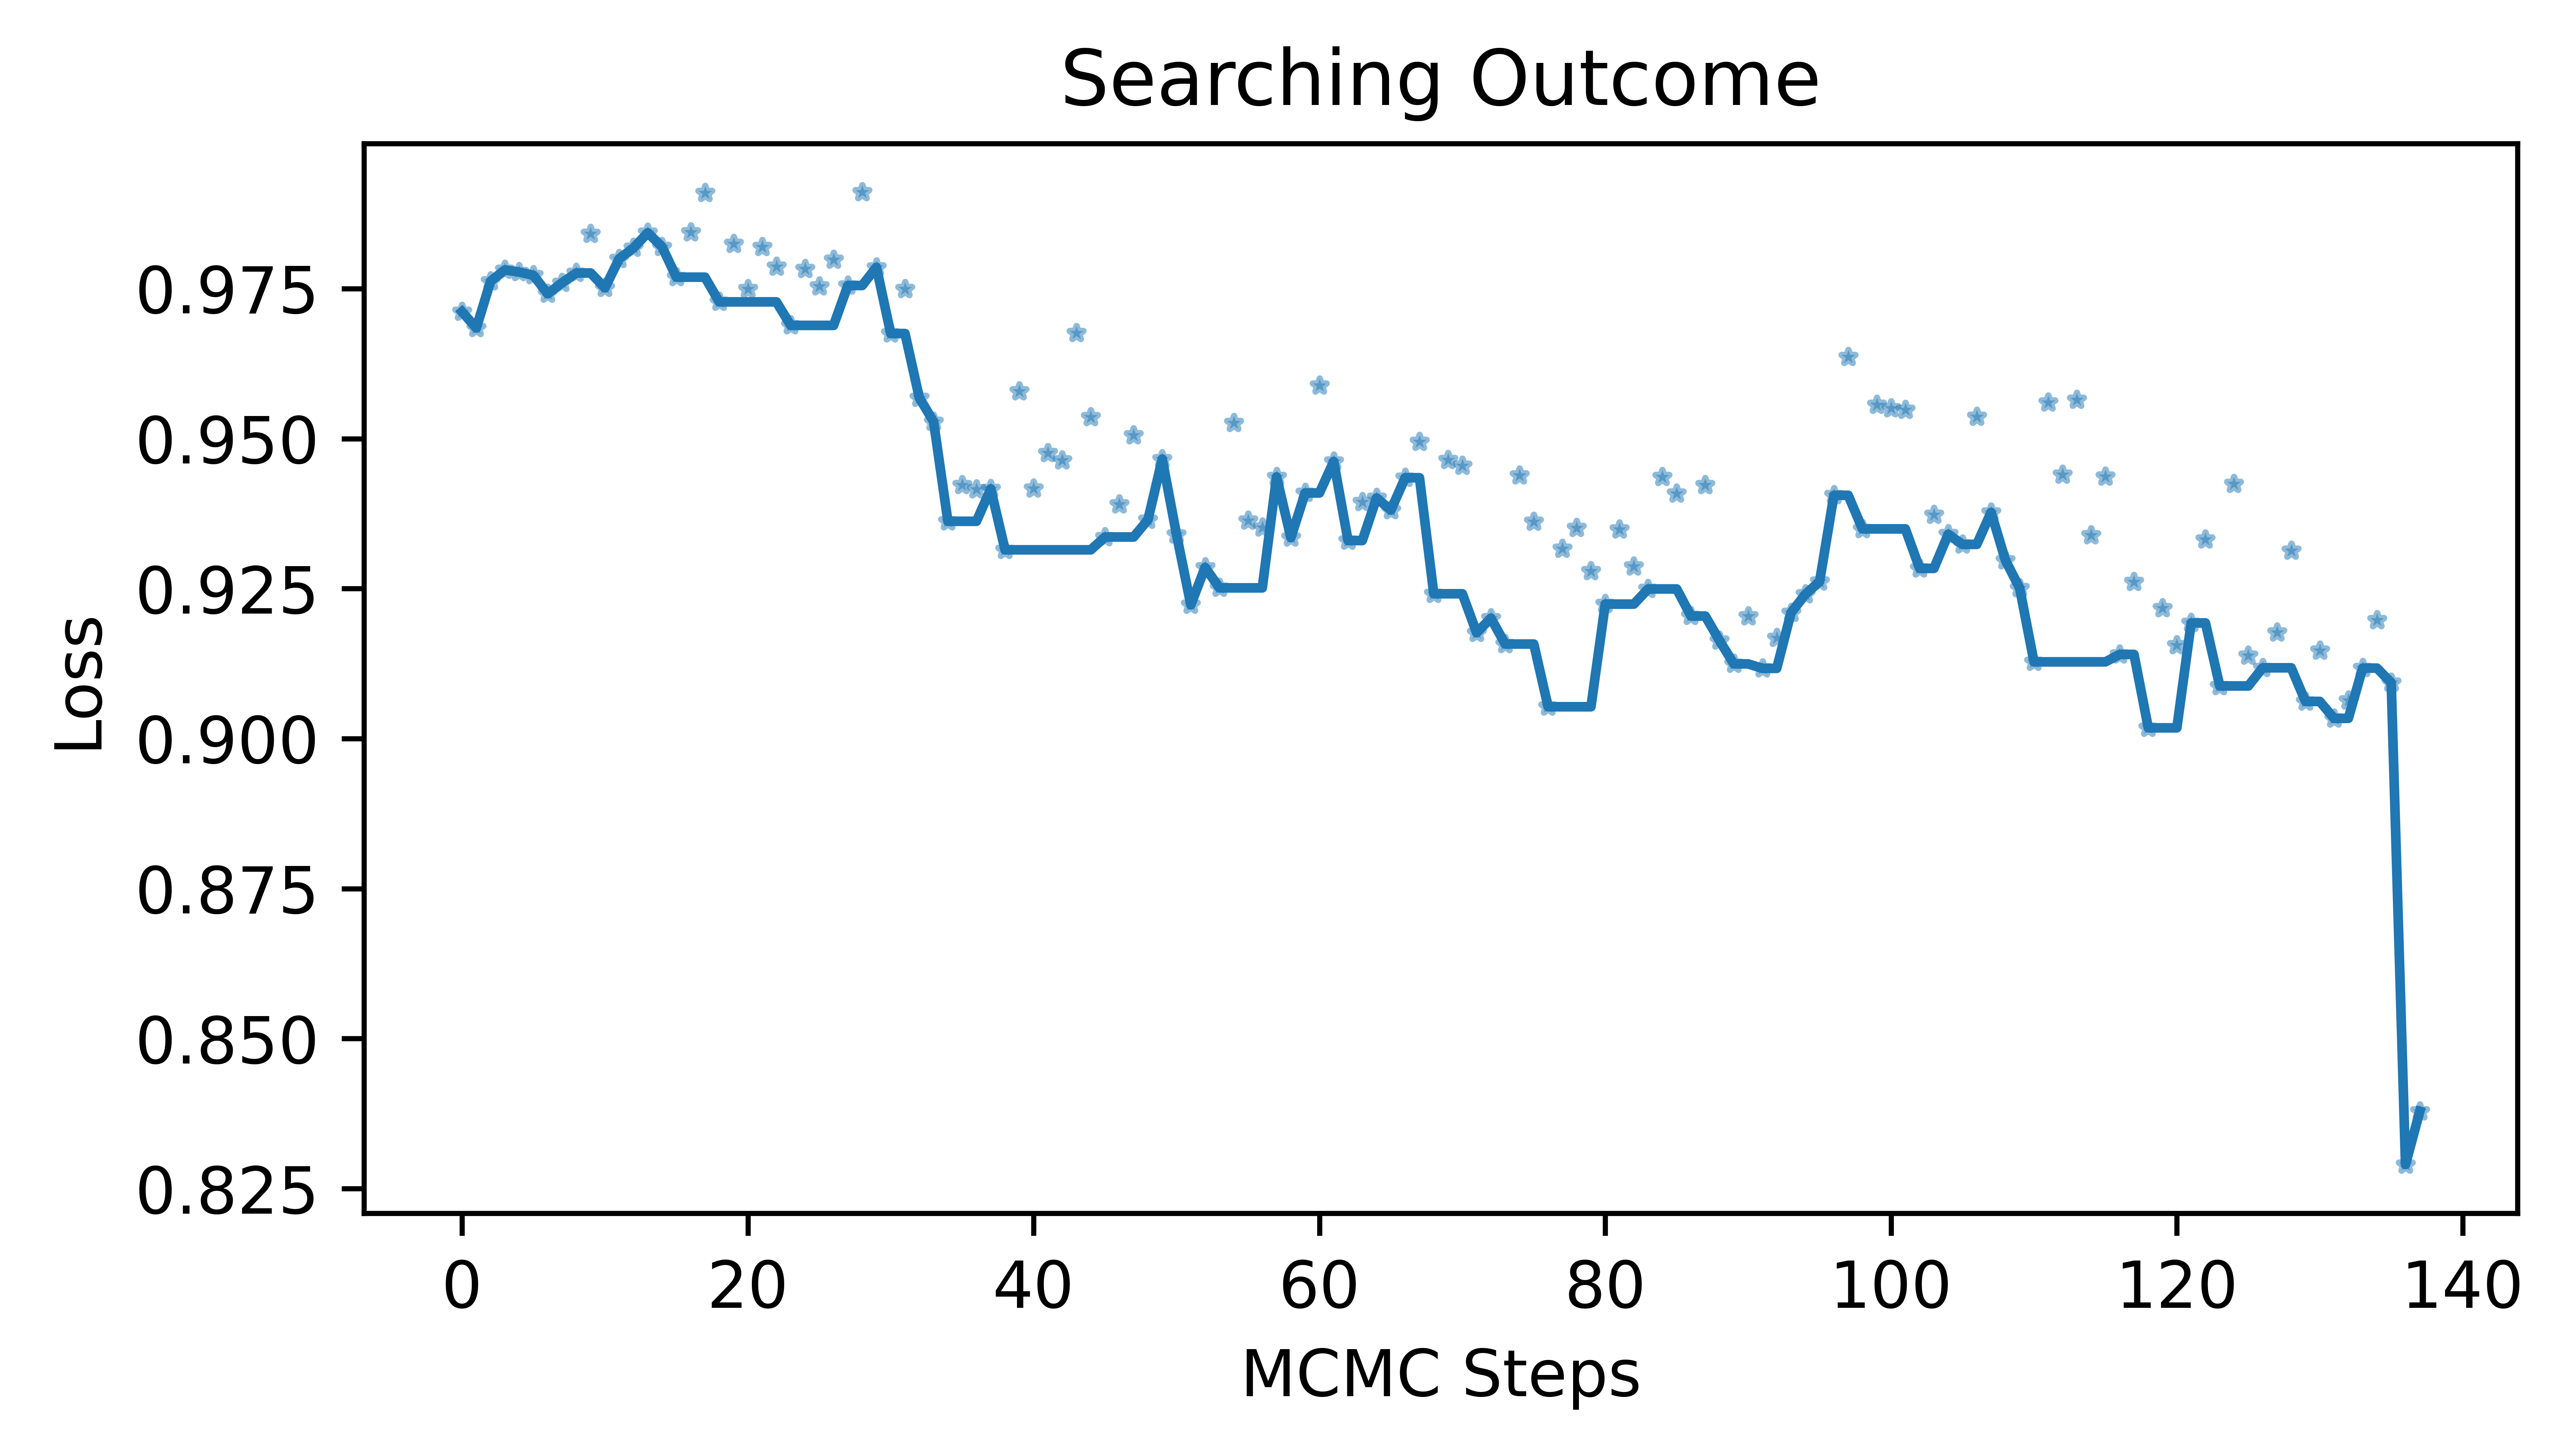

In [5]:
#@title Start Hallucinating!

import gc
import torch
import numpy as np

if 'logger' in dir():
  del logger

if torch.cuda.is_available():
  torch.cuda.empty_cache()

gc.collect()

leng = len(Initial_Sequence) if Start_From_Known_Sequence else Length
seqc = Initial_Sequence if Start_From_Known_Sequence else None
mutn = Initial_Mutation_Rate if Start_From_Known_Sequence else 0
exaa = Exclude_Amino_Acid.split(';')
job_name = None if Jobname == 'UUID4' else Jobname
pres_resid = np.asarray(Preserved_Residues.split(';')).astype('int') if Start_From_Known_Sequence else None
seqc = [seqc, None, mutn] if Start_From_Known_Sequence else None

logger = Protein_History_MCMC_Logger(
        length=leng, excluded_aas=exaa, temp=[.05, .01, (1e-9, 5)], step=Steps,
        free_guess=N_Free_Guess, seqc_provided=seqc, preserve_resid=pres_resid,
        temp_control='Adaptive', job_name=job_name,
        guess_loss_ignore=['TruncatedAveragePLDDTLoss', 'MoleculeBindingAffinityLoss'],
        plddt_loss=PLDDTLoss, pos_loss=POSLoss,
        form_loss=lambda x, y: x+y, plddt_rule=np.mean,
        pos_rule=np.sum if Loss_Rule=='Sum' else np.max,
        loss_info=True, server_online=(useESMFold=='online'))

logger.mcmc(print_level=Output_Render_Frequency, allow_convergence=0)


In [13]:
logger.loss.plddt_func[0].calculate_loss(logger.curr_pldd,logger.job_name)
logger.loss.pos_func[0].calculate_loss(logger.curr_stru,logger.curr_pldd,logger.job_name)
logger.loss.pos_func[0].target_density

5